# Data Integration & MFCI Creation

This notebook combines multiple data sources and creates the Macro-Financial Composite Index (MFCI) using the BIS/IMF research framework.

**Data Sources:**
- OECD MEI: Country-level economic indicators
- BIS: Credit and REER data
- FRED: US macroeconomic variables (global factors)

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

In [2]:
# Configuration
DROP_COUNTRIES = ["AUS", "NZL", "TUR"]
PERIOD_START = "1995-01"
PERIOD_END = "2023-12"
DATA_PATH = "../data/cleaned data"

In [3]:
# Load all datasets
try:
    oecd_mei = pd.read_csv(os.path.join(DATA_PATH, "final_oecd_mei.csv"))
    credit = pd.read_csv(os.path.join(DATA_PATH, "bis_credit_data_cleaned.csv"))
    reer = pd.read_csv(os.path.join(DATA_PATH, "bis_reer_data_cleaned.csv"))
    fedfunds = pd.read_csv(os.path.join(DATA_PATH, "fedfunds_cleaned.csv"))
    indpro = pd.read_csv(os.path.join(DATA_PATH, "indpro_cleaned.csv"))
    oilprice = pd.read_csv(os.path.join(DATA_PATH, "oil_prices_cleaned.csv"))
    termspread = pd.read_csv(os.path.join(DATA_PATH, "term_spread_cleaned.csv"))
    vix = pd.read_csv(os.path.join(DATA_PATH, "vixcls_cleaned.csv"))
    print("All datasets loaded successfully")
except Exception as e:
    print(f"Error loading data: {e}")

All datasets loaded successfully


---
## 1. Data Preparation

### 1.1 OECD MEI Data

In [4]:
oecd_mei['Period'] = pd.to_datetime(oecd_mei['Date']).dt.to_period('M').astype(str)

oecd_mei_filtered = oecd_mei[
    (oecd_mei['Period'] >= PERIOD_START) & 
    (oecd_mei['Period'] <= PERIOD_END) &
    (~oecd_mei['Country'].isin(DROP_COUNTRIES))
].drop('Date', axis=1).sort_values(['Country', 'Period']).reset_index(drop=True)

print(f"Shape: {oecd_mei_filtered.shape}")
print(f"Countries: {oecd_mei_filtered['Country'].nunique()}")
print(f"Period: {oecd_mei_filtered['Period'].min()} to {oecd_mei_filtered['Period'].max()}")
oecd_mei_filtered.head()

Shape: (7440, 13)
Countries: 28
Period: 1995-01 to 2023-12


,Country,CPI,IP,LongRate,ShortRate,Stocks,Inflation_YoY,Inflation_MoM,IP_Growth_YoY,Term_Spread,Real_Short_Rate,Real_Stock_Return,Period
0,AUT,-0.082057,61.705246,3.8426,3.1370,-2.612145,-2302.585093,-2302.585093,3.562020,0.7056,2305.722093,2309.855963,1999-01
1,AUT,0.191624,60.957807,3.9840,3.1180,3.490020,-0.493427,-2302.585093,1.925782,0.8660,3.611427,0.000000,1999-02
2,AUT,-0.190891,64.279758,4.5399,2.5632,-3.013989,55.469104,-2302.585093,5.034175,1.9767,-52.905904,0.000000,1999-06
3,AUT,0.081565,71.588051,5.2710,2.9355,3.980668,-29.559804,-161.353457,15.125465,2.3355,32.495304,-2141.231636,1999-11
4,AUT,0.679163,66.771222,5.3528,3.0418,-1.317591,211.262282,211.945572,10.480788,2.3110,-208.220482,-2514.530665,1999-12


### 1.2 BIS Credit & REER Data

In [5]:
credit = credit.rename(columns={'0': 'Period'}) if '0' in credit.columns else credit
reer = reer.rename(columns={'0': 'Period'}) if '0' in reer.columns else reer

# Expand quarterly credit data to monthly (backward fill)
credit['Period'] = pd.to_datetime(credit['Period']) + pd.offsets.QuarterEnd(0)
credit_monthly = []
for _, row in credit.iterrows():
    for offset in range(-2, 1):
        monthly_row = row.copy()
        monthly_row['Period'] = row['Period'] + pd.DateOffset(months=offset)
        credit_monthly.append(monthly_row)
credit = pd.DataFrame(credit_monthly)

# Convert to long format
credit_long = credit.melt(id_vars=['Period'], var_name='Country', value_name='Credit')
reer_long = reer.melt(id_vars=['Period'], var_name='Country', value_name='REER')

# Format periods
credit_long['Period'] = pd.to_datetime(credit_long['Period']).dt.to_period('M').astype(str)
reer_long['Period'] = pd.to_datetime(reer_long['Period']).dt.to_period('M').astype(str)

# Merge and filter
bis_merged = credit_long.merge(reer_long, on=['Period', 'Country'], how='outer')
bis_merged = bis_merged[
    (bis_merged['Period'] >= PERIOD_START) & 
    (bis_merged['Period'] <= PERIOD_END) &
    (~bis_merged['Country'].isin(DROP_COUNTRIES))
].sort_values(['Country', 'Period']).reset_index(drop=True)

print(f"Shape: {bis_merged.shape}")
print(f"Countries: {bis_merged['Country'].nunique()}")
bis_merged.head()

Shape: (11832, 4)
Countries: 34


,Period,Country,Credit,REER
0,1995-01,AUT,102.7,105.08
1,1995-02,AUT,102.7,105.54
2,1995-03,AUT,102.7,108.24
3,1995-04,AUT,103.5,108.27
4,1995-05,AUT,103.5,107.16


### 1.3 FRED Data (Global Factors)

In [6]:
fred_dfs = [
    ('fedfunds', fedfunds),
    ('indpro', indpro),
    ('oilprice', oilprice),
    ('termspread', termspread),
    ('vix', vix)
]

for name, df in fred_dfs:
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', axis=1, inplace=True)
    if 'Date' in df.columns:
        df.rename(columns={'Date': 'Period'}, inplace=True)
    if 'raw_eom' in df.columns:
        df.rename(columns={'raw_eom': f'{name}_raw_eom', 'ema_eom': f'{name}_ema_eom'}, inplace=True)

fred_merged = fedfunds
for name, df in [('indpro', indpro), ('oilprice', oilprice), ('termspread', termspread), ('vix', vix)]:
    fred_merged = fred_merged.merge(df, on='Period', how='outer')

fred_merged['Period'] = pd.to_datetime(fred_merged['Period']).dt.to_period('M').astype(str)
fred_merged = fred_merged[
    (fred_merged['Period'] >= PERIOD_START) & 
    (fred_merged['Period'] <= PERIOD_END)
].sort_values('Period').reset_index(drop=True)

print(f"Shape: {fred_merged.shape}")
print(f"Period: {fred_merged['Period'].min()} to {fred_merged['Period'].max()}")
fred_merged.head()

Shape: (348, 9)
Period: 1995-01 to 2023-12


,Period,FEDFUNDS,INDPRO,oilprice_raw_eom,oilprice_ema_eom,termspread_raw_eom,termspread_ema_eom,vix_raw_eom,vix_ema_eom
0,1995-01,5.53,71.2635,16.80,16.463141,0.34,0.396405,11.96,13.275978
1,1995-02,5.92,71.1758,17.23,16.795364,0.43,0.381139,11.75,12.393002
2,1995-03,5.98,71.2796,17.98,16.972039,0.40,0.407249,13.37,12.252729
3,1995-04,6.05,71.1538,18.98,17.811175,0.47,0.455312,11.75,12.293218
4,1995-05,6.01,71.4997,17.58,18.053913,0.41,0.453750,12.85,12.273605


---
## 2. Data Integration

In [7]:
combined_data = oecd_mei_filtered.copy()
combined_data = combined_data.sort_values(['Country', 'Period']).reset_index(drop=True)

# Merge BIS data (country-specific)
combined_data = combined_data.merge(bis_merged, on=['Period', 'Country'], how='left')

# Merge FRED data (common for all countries)
combined_data = combined_data.merge(fred_merged, on='Period', how='left')

# Sort final combined data
combined_data = combined_data.sort_values(['Country', 'Period']).reset_index(drop=True)

print(f"Final shape: {combined_data.shape}")
print(f"Countries: {combined_data['Country'].nunique()}")
print(f"Columns: {len(combined_data.columns)}")
combined_data.head()

Final shape: (7440, 23)
Countries: 28
Columns: 23


,Country,CPI,IP,LongRate,ShortRate,Stocks,Inflation_YoY,Inflation_MoM,IP_Growth_YoY,Term_Spread,Real_Short_Rate,Real_Stock_Return,Period,Credit,REER,FEDFUNDS,INDPRO,oilprice_raw_eom,oilprice_ema_eom,termspread_raw_eom,termspread_ema_eom,vix_raw_eom,vix_ema_eom
0,AUT,-0.082057,61.705246,3.8426,3.1370,-2.612145,-2302.585093,-2302.585093,3.562020,0.7056,2305.722093,2309.855963,1999-01,113.5,100.63,4.63,87.2205,11.34,10.926377,0.08,0.147588,26.25,27.722458
1,AUT,0.191624,60.957807,3.9840,3.1180,3.490020,-0.493427,-2302.585093,1.925782,0.8660,3.611427,0.000000,1999-02,113.5,100.05,4.76,87.7260,10.58,10.598135,0.16,0.136574,27.88,28.247284
2,AUT,-0.190891,64.279758,4.5399,2.5632,-3.013989,55.469104,-2302.585093,5.034175,1.9767,-52.905904,0.000000,1999-06,114.6,97.86,4.76,88.5903,16.97,15.264967,0.28,0.258631,21.09,24.391914
3,AUT,0.081565,71.588051,5.2710,2.9355,3.980668,-29.559804,-161.353457,15.125465,2.3355,32.495304,-2141.231636,1999-11,121.0,97.16,5.42,90.7528,25.20,23.254925,0.17,0.204373,24.18,22.785704
4,AUT,0.679163,66.771222,5.3528,3.0418,-1.317591,211.262282,211.945572,10.480788,2.3110,-208.220482,-2514.530665,1999-12,121.0,97.00,5.30,91.4784,24.93,24.417311,0.21,0.187057,24.64,22.526399


### 2.1 Data Quality Check

In [8]:
print(f"Total observations: {len(combined_data):,}")
print(f"Countries: {combined_data['Country'].nunique()}")
print(f"Time periods: {combined_data['Period'].nunique()}")
print(f"Variables: {len(combined_data.columns)}")
print(f"\nCountries: {sorted(combined_data['Country'].unique())}")

Total observations: 7,440
Countries: 28
Time periods: 348
Variables: 23

Countries: ['AUT', 'BEL', 'CAN', 'CHE', 'CHL', 'COL', 'CZE', 'DEU', 'DNK', 'ESP', 'FIN', 'FRA', 'GBR', 'GRC', 'HUN', 'IRL', 'ISR', 'ITA', 'JPN', 'KOR', 'LUX', 'MEX', 'NLD', 'NOR', 'POL', 'PRT', 'SWE', 'USA']


### 2.2 Missing Data Analysis

In [9]:
# Overall missing data summary
null_counts = combined_data.isnull().sum()
null_percent = (null_counts / len(combined_data) * 100).round(2)

null_summary = pd.DataFrame({
    'Column': null_counts.index,
    'Missing': null_counts.values,
    'Percent': null_percent.values
}).query('Missing > 0').sort_values('Percent', ascending=False)

print(f"Total missing: {combined_data.isnull().sum().sum():,} ({(combined_data.isnull().sum().sum() / combined_data.size * 100):.2f}%)\n")
print("Missing data by variable:")
print(null_summary.to_string(index=False))

# Missing data by country
print("\n" + "="*80)
print("MISSING DATA BY COUNTRY")
print("="*80)

country_missing = combined_data.groupby('Country').apply(
    lambda x: pd.Series({
        'Total_Missing': x.isnull().sum().sum(),
        'Missing_Percent': (x.isnull().sum().sum() / x.size * 100),
        'Observations': len(x)
    })
).sort_values('Missing_Percent', ascending=False)

print(country_missing.round(2).to_string())

# Detailed: Which variables are missing for which countries
print("\n" + "="*80)
print("CRITICAL MISSING DATA: COUNTRIES × VARIABLES")
print("="*80)

# Create pivot showing missing % for each country-variable combination
missing_pivot = combined_data.groupby('Country').apply(
    lambda x: (x.isnull().sum() / len(x) * 100).round(1)
).T

# Show only variables with >10% missing for any country
critical_vars = missing_pivot[missing_pivot.max(axis=1) > 10]

if len(critical_vars) > 0:
    print("\nVariables with >10% missing (showing top problematic):")
    print(critical_vars.sort_values(by=critical_vars.columns[0], ascending=False).head(10).to_string())
else:
    print("\nNo critical missing data issues")

# Countries with most missing data for key variables
key_vars = ['Credit', 'REER', 'Credit_Growth_YoY', 'REER_Growth_YoY']
available_key_vars = [v for v in key_vars if v in combined_data.columns]

if available_key_vars:
    print("\n" + "="*80)
    print(f"KEY VARIABLES AVAILABILITY: {available_key_vars}")
    print("="*80)
    
    key_missing = combined_data.groupby('Country')[available_key_vars].apply(
        lambda x: (x.isnull().sum() / len(x) * 100).round(1)
    )
    
    print(key_missing.to_string())

Total missing: 112 (0.07%)

Missing data by variable:
Column  Missing  Percent
Credit      112     1.51

MISSING DATA BY COUNTRY
         Total_Missing  Missing_Percent  Observations
Country                                              
CZE                5.0             0.12         177.0
NOR                5.0             0.09         231.0
CHE                3.0             0.09         140.0
KOR                5.0             0.09         240.0
GBR                5.0             0.09         243.0
COL                5.0             0.09         248.0
CHL                4.0             0.08         215.0
FIN                5.0             0.08         277.0
BEL                5.0             0.08         289.0
ISR                4.0             0.07         232.0
LUX                5.0             0.07         291.0
NLD                5.0             0.07         293.0
PRT                5.0             0.07         299.0
HUN                4.0             0.07         242.0
IRL    

---
## 3. MFCI Creation

Building Macro-Financial Composite Index using PCA on 4 pillars:
1. **Real Economy**: IP growth, industrial production
2. **Prices & Monetary**: Inflation, rates, yield curve
3. **Financial Markets**: Stock returns, VIX, term spreads
4. **Credit & External**: Credit growth, REER, oil prices

In [10]:
print("="*80)
print("MFCI CREATION USING PCA")
print("="*80)

MFCI CREATION USING PCA


In [11]:
def create_stationary_features(df):
    df = df.copy()
    df = df.sort_values(["Country", "Period"])

    # CREDIT GROWTH (YoY)
    if 'Credit' in df.columns:
        df['Credit_Growth_YoY'] = (
            df.groupby('Country')['Credit'].pct_change(12) * 100
        )

    # REER GROWTH (YoY)
    if 'REER' in df.columns:
        df['REER_Growth_YoY'] = (
            df.groupby('Country')['REER'].pct_change(12) * 100
        )

    # IP MOM growth
    df['IP_Growth_MoM'] = df.groupby("Country")['IP'].pct_change() * 100

    return df


combined_data_mfci = create_stationary_features(combined_data)
print("Stationary features created.")


Stationary features created.


In [12]:
mfci_indicators = [
    'IP_Growth_YoY',
    'indpro_raw_eom',         
    'Inflation_YoY',
    'Real_Short_Rate',
    'Term_Spread',
    'fedfunds_raw_eom',
    'termspread_raw_eom',
    'Real_Stock_Return',
    'vix_raw_eom',
    'Credit_Growth_YoY',
    'REER_Growth_YoY',
    'oilprice_raw_eom'
]

# keep only indicators actually available in your dataset
available_indicators = [
    col for col in mfci_indicators 
    if col in combined_data_mfci.columns
]

print(f"Using {len(available_indicators)}/{len(mfci_indicators)} indicators:")
print(available_indicators)


Using 10/12 indicators:
['IP_Growth_YoY', 'Inflation_YoY', 'Real_Short_Rate', 'Term_Spread', 'termspread_raw_eom', 'Real_Stock_Return', 'vix_raw_eom', 'Credit_Growth_YoY', 'REER_Growth_YoY', 'oilprice_raw_eom']


In [13]:
GLOBAL_VARS = [
    'indpro_raw_eom', 'fedfunds_raw_eom', 'vix_raw_eom', 'oilprice_raw_eom'
]

def create_country_mfci(country_df, indicators):
    country_df = country_df.sort_values("Period").copy()
    X = country_df[indicators].copy()

    # Require at least 70% non-missing indicators per row
    row_valid = X.notna().sum(axis=1) >= 0.7 * len(indicators)
    X = X[row_valid]

    if X.shape[0] < 24:
        return None, None, None  # too little data

    # Fill ONLY global variables (safe)
    for g in GLOBAL_VARS:
        if g in X.columns:
            X[g] = X[g].ffill().bfill()

    # Drop rows still too empty
    X = X.dropna(thresh=int(0.7 * len(indicators)))
    if X.shape[0] < 24:
        return None, None, None

    # If fewer than 5 indicators remain, PCA is unreliable
    if X.notna().sum(axis=0).gt(0).sum() < 5:
        return None, None, None

    # Forward-fill remaining missing domestic data *slightly*, but not across wide gaps
    X = X.fillna(method='ffill').fillna(method='bfill')

    # Standardize
    X_scaled = StandardScaler().fit_transform(X)

    # PCA
    pca = PCA(n_components=1)
    mfci_vals = pca.fit_transform(X_scaled).flatten()

    return mfci_vals, pca.explained_variance_ratio_[0], X.index


# Apply across all countries
mfci_results = {}
combined_data_mfci['MFCI_raw'] = np.nan

for country in sorted(combined_data_mfci['Country'].unique()):
    cdf = combined_data_mfci[combined_data_mfci['Country'] == country]
    mfci, exp_var, idx = create_country_mfci(cdf, available_indicators)

    if mfci is not None:
        mfci_results[country] = {
            "explained_var": exp_var,
            "n_obs": len(mfci)
        }
        combined_data_mfci.loc[idx, "MFCI_raw"] = mfci

print(f"MFCI extracted for {len(mfci_results)} countries.")

MFCI extracted for 28 countries.


In [14]:
# Smooth the factor (3-month centered rolling average)
combined_data_mfci['MFCI_smooth'] = (
    combined_data_mfci.groupby('Country')['MFCI_raw']
    .transform(lambda x: x.rolling(3, center=True, min_periods=1).mean())
)

# Normalize per country (z-score)
def normalize_country(group):
    series = group['MFCI_smooth']
    valid = series.notna()

    if valid.sum() > 0:
        mean = series.mean()
        std = series.std()
        if std > 0:
            group.loc[valid, 'MFCI'] = (series[valid] - mean) / std
        else:
            group.loc[valid, 'MFCI'] = 0  # rare case: flat line
    return group

combined_data_mfci['MFCI'] = np.nan
combined_data_mfci = (
    combined_data_mfci.groupby('Country', group_keys=False)
    .apply(normalize_country)
)

print("MFCI smoothed and normalized.")


MFCI smoothed and normalized.


In [15]:
# Summary
print("\n" + "="*80)
mfci_stats = combined_data_mfci.groupby('Country')['MFCI'].agg(['count', 'mean', 'std']).round(3)
print(f"MFCI Coverage: {combined_data_mfci['MFCI'].notna().sum():,} / {len(combined_data_mfci):,} ({combined_data_mfci['MFCI'].notna().mean():.1%})")
print("\nTop countries by explained variance:")
for country, res in sorted(mfci_results.items(), key=lambda x: x[1]['explained_var'], reverse=True)[:10]:
    print(f"  {country}: {res['explained_var']:.1%}")


MFCI Coverage: 7,440 / 7,440 (100.0%)

Top countries by explained variance:
  USA: 29.1%
  DEU: 26.5%
  MEX: 26.3%
  CAN: 24.6%
  CHE: 24.3%
  GBR: 24.1%
  CHL: 24.1%
  HUN: 24.1%
  SWE: 24.0%
  CZE: 23.8%


In [16]:
# Create wide-format MFCI matrix (Countries × Time)
mfci_wide = combined_data_mfci.pivot_table(
    index='Period',
    columns='Country',
    values='MFCI'
).sort_index()

print(f"MFCI matrix shape: {mfci_wide.shape}")
print(f"Coverage: {mfci_wide.notna().sum().sum():,} / {mfci_wide.size:,} "
      f"({mfci_wide.notna().sum().sum() / mfci_wide.size:.1%})")

# Drop periods where <50% countries have data
valid_periods = mfci_wide.notna().sum(axis=1) >= 0.5 * mfci_wide.shape[1]
mfci_wide_clean = mfci_wide[valid_periods].copy()

print(f"Valid periods: {valid_periods.sum()} / {len(valid_periods)}")

# Forward-fill missing values (only short gaps allowed)
mfci_wide_filled = (
    mfci_wide_clean
    .fillna(method='ffill', limit=3)
    .fillna(method='bfill', limit=3)
)

# Drop countries with <60% data availability
country_coverage = mfci_wide_filled.notna().sum() / len(mfci_wide_filled)
valid_countries = country_coverage[country_coverage >= 0.60].index

mfci_wide_final = mfci_wide_filled[valid_countries].copy()

print(f"Countries with sufficient data: {len(valid_countries)} / {mfci_wide_filled.shape[1]}")
print("Countries included:", sorted(valid_countries.tolist()))

MFCI matrix shape: (348, 28)
Coverage: 7,440 / 9,744 (76.4%)
Valid periods: 299 / 348
Countries with sufficient data: 27 / 28
Countries included: ['AUT', 'BEL', 'CAN', 'CHL', 'COL', 'CZE', 'DEU', 'DNK', 'ESP', 'FIN', 'FRA', 'GBR', 'GRC', 'HUN', 'IRL', 'ISR', 'ITA', 'JPN', 'KOR', 'LUX', 'MEX', 'NLD', 'NOR', 'POL', 'PRT', 'SWE', 'USA']


In [17]:
# Standardize each country (mean 0, std 1)
# (Ensures no country dominates PCA due to higher volatility)
mfci_standardized = mfci_wide_final.apply(
    lambda x: (x - x.mean()) / x.std(ddof=0)
)

# Extract Global Factors using PCA

print("\n" + "-"*80)
print("Extracting Global Factors...")
print("-"*80)

pca_global = PCA(
    n_components=min(5, len(valid_countries)),
    svd_solver='full'
)

# Fill remaining NA with column means (safer than zero)
X_pca = mfci_standardized.fillna(mfci_standardized.mean())

global_factors_array = pca_global.fit_transform(X_pca)

# Create DataFrame of global factors
global_cycles = pd.DataFrame(
    global_factors_array,
    index=mfci_standardized.index,
    columns=[f'Global_Factor_{i+1}' for i in range(global_factors_array.shape[1])]
)

# Print Explained Variances
explained_var = pca_global.explained_variance_ratio_

print("\nGlobal Factor Decomposition:")
for i, var in enumerate(explained_var):
    print(f"  Factor {i+1}: {var:.1%} variance explained")
print(f"  Cumulative (first 3): {explained_var[:3].sum():.1%}")

# Country Loadings (PCA components)
loadings = pd.DataFrame(
    pca_global.components_.T,
    index=valid_countries,
    columns=[f'Factor_{i+1}' for i in range(len(explained_var))]
)

print("\n" + "-"*80)
print("Country Loadings on Global Factor 1 (Global Cycle):")
print("-"*80)
print(loadings['Factor_1'].sort_values(ascending=False).round(3).to_string())


--------------------------------------------------------------------------------
Extracting Global Factors...
--------------------------------------------------------------------------------

Global Factor Decomposition:
  Factor 1: 33.2% variance explained
  Factor 2: 26.2% variance explained
  Factor 3: 7.3% variance explained
  Factor 4: 5.5% variance explained
  Factor 5: 4.0% variance explained
  Cumulative (first 3): 66.7%

--------------------------------------------------------------------------------
Country Loadings on Global Factor 1 (Global Cycle):
--------------------------------------------------------------------------------
Country
POL    0.257
NLD    0.253
CHL    0.235
BEL    0.234
NOR    0.221
DNK    0.220
KOR    0.216
AUT    0.204
CZE    0.199
GBR    0.198
GRC    0.126
ISR    0.123
LUX    0.098
JPN    0.069
ITA    0.041
PRT   -0.082
HUN   -0.108
DEU   -0.155
USA   -0.173
COL   -0.189
FRA   -0.196
ESP   -0.205
SWE   -0.205
FIN   -0.227
IRL   -0.227
CAN   -0.240
MEX  

In [18]:
# Regional Synchronization
regions = {
    'Europe': ['AUT','BEL','CHE','CZE','DEU','DNK','ESP','FIN','FRA','GBR','GRC',
               'HUN','IRL','ITA','LUX','NLD','NOR','POL','PRT','SWE'],
    'Americas': ['USA','CAN','MEX','CHL','COL'],
    'Asia_Pacific': ['JPN','KOR','ISR']
}

print("\n" + "-"*80)
print("Regional Synchronization with Global Cycle:")
print("-"*80)

for region, countries in regions.items():
    available = [c for c in countries if c in valid_countries]
    if available:
        avg_loading = loadings.loc[available, 'Factor_1'].mean()
        print(f"  {region:15s}: {avg_loading:.3f}  (n={len(available)})")

# Global Synchronization Index
sync_index = loadings['Factor_1'].abs().mean()
print(f"\nGlobal Synchronization Index: {sync_index:.3f}")
print("  (Higher = stronger global co-movement across countries)")
    
# Merge Global Factor 1 back into main dataset
combined_data_final = combined_data_mfci.merge(
    global_cycles[['Global_Factor_1']].reset_index().rename(columns={'index': 'Period'}),
    on='Period',
    how='left'
)

print("\nGlobal Factor added to dataset.")
print("Final dataset shape:", combined_data_final.shape)


--------------------------------------------------------------------------------
Regional Synchronization with Global Cycle:
--------------------------------------------------------------------------------
  Europe         : 0.034  (n=19)
  Americas       : -0.122  (n=5)
  Asia_Pacific   : 0.136  (n=3)

Global Synchronization Index: 0.183
  (Higher = stronger global co-movement across countries)

Global Factor added to dataset.
Final dataset shape: (7440, 30)


In [19]:
# Create MFCI output directory
MFCI_OUTPUT_DIR = os.path.join("..", "data", "mfci")
os.makedirs(MFCI_OUTPUT_DIR, exist_ok=True)

print("="*80)
print("SAVING MFCI OUTPUTS")
print("="*80)

# 1. Save main dataset with MFCI and Global Factor
output_main = os.path.join(MFCI_OUTPUT_DIR, "mfci_complete_dataset.csv")
combined_data_final.to_csv(output_main, index=False)
print(f"Main dataset: {output_main}")

# 2. Save country-level MFCI only (for easy plotting)
mfci_only = combined_data_final[['Country', 'Period', 'MFCI', 'MFCI_raw', 'MFCI_smooth']].dropna(subset=['MFCI'])
output_mfci = os.path.join(MFCI_OUTPUT_DIR, "country_mfci.csv")
mfci_only.to_csv(output_mfci, index=False)
print(f"Country MFCI: {output_mfci}")

# 3. Save global cycles
output_global = os.path.join(MFCI_OUTPUT_DIR, "global_cycles.csv")
global_cycles.to_csv(output_global)
print(f"Global cycles: {output_global}")

# 4. Save country loadings
output_loadings = os.path.join(MFCI_OUTPUT_DIR, "country_loadings.csv")
loadings.to_csv(output_loadings)
print(f"Country loadings: {output_loadings}")

# 5. Save MFCI summary statistics
mfci_summary = combined_data_final.groupby('Country')['MFCI'].agg([
    ('observations', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max')
]).round(3)
mfci_summary['explained_var'] = mfci_summary.index.map(
    lambda c: mfci_results.get(c, {}).get('explained_var', np.nan)
)
output_summary = os.path.join(MFCI_OUTPUT_DIR, "mfci_summary_stats.csv")
mfci_summary.to_csv(output_summary)
print(f"Summary stats: {output_summary}")

# 6. Save wide-format MFCI matrix (for correlation analysis)
output_wide = os.path.join(MFCI_OUTPUT_DIR, "mfci_wide_matrix.csv")
mfci_wide_final.to_csv(output_wide)
print(f"MFCI wide matrix: {output_wide}")

# 7. Save metadata
metadata = {
    'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'period_start': PERIOD_START,
    'period_end': PERIOD_END,
    'total_countries': len(mfci_results),
    'total_observations': len(combined_data_final),
    'mfci_coverage': f"{combined_data_final['MFCI'].notna().mean():.1%}",
    'indicators_used': len(available_indicators),
    'global_sync_index': f"{sync_index:.3f}",
    'global_factor1_explained_var': f"{explained_var[0]:.1%}"
}
metadata_df = pd.DataFrame([metadata])
output_meta = os.path.join(MFCI_OUTPUT_DIR, "mfci_metadata.csv")
metadata_df.to_csv(output_meta, index=False)
print(f"Metadata: {output_meta}")

print("\n" + "="*80)
print(f"ALL OUTPUTS SAVED TO: {MFCI_OUTPUT_DIR}")
print("="*80)

SAVING MFCI OUTPUTS
Main dataset: ../data/mfci/mfci_complete_dataset.csv
Main dataset: ../data/mfci/mfci_complete_dataset.csv
Country MFCI: ../data/mfci/country_mfci.csv
Global cycles: ../data/mfci/global_cycles.csv
Country loadings: ../data/mfci/country_loadings.csv
Summary stats: ../data/mfci/mfci_summary_stats.csv
MFCI wide matrix: ../data/mfci/mfci_wide_matrix.csv
Metadata: ../data/mfci/mfci_metadata.csv

ALL OUTPUTS SAVED TO: ../data/mfci
Country MFCI: ../data/mfci/country_mfci.csv
Global cycles: ../data/mfci/global_cycles.csv
Country loadings: ../data/mfci/country_loadings.csv
Summary stats: ../data/mfci/mfci_summary_stats.csv
MFCI wide matrix: ../data/mfci/mfci_wide_matrix.csv
Metadata: ../data/mfci/mfci_metadata.csv

ALL OUTPUTS SAVED TO: ../data/mfci


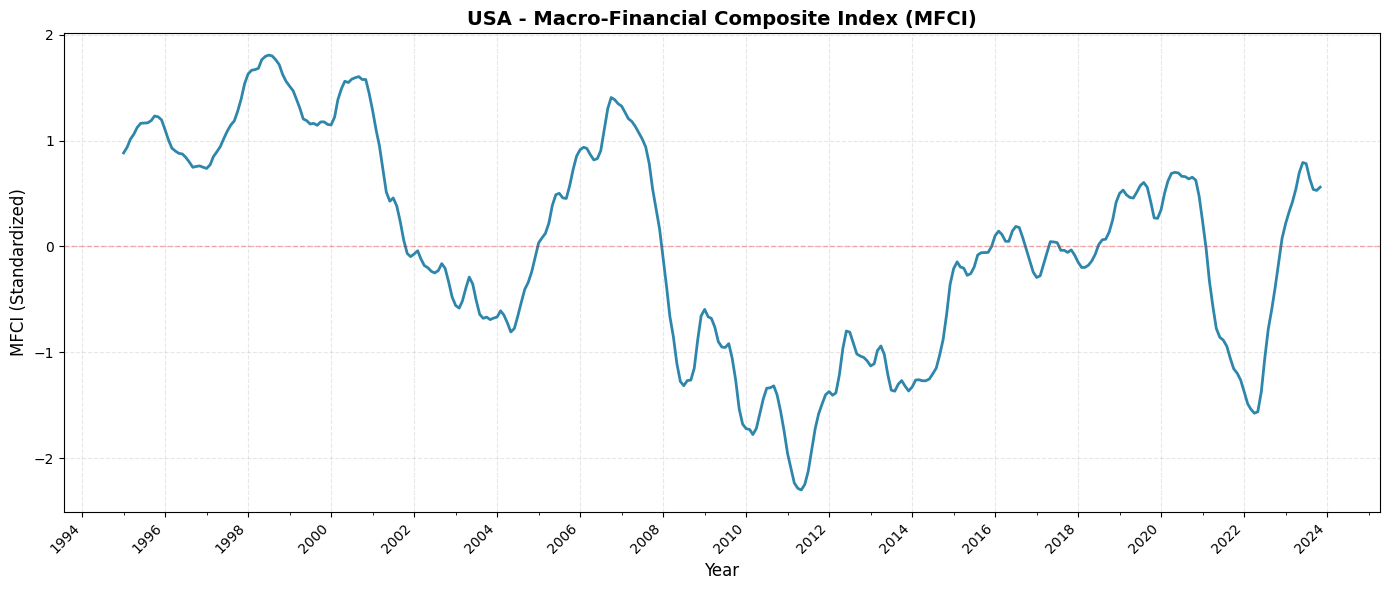

USA MFCI Statistics:
  Mean: -0.000
  Std:  1.000
  Min:  -2.301 (2011-05)
  Max:  1.808 (1998-07)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter for USA
usa_df = combined_data_final[combined_data_final["Country"] == "USA"].copy()
usa_df = usa_df.sort_values("Period")

# Convert Period to datetime for proper plotting
usa_df['Period_dt'] = pd.to_datetime(usa_df['Period'])

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(usa_df['Period_dt'], usa_df['MFCI'], linewidth=2, color='#2E86AB')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.3, linewidth=1)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(2))  # Every 2 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))  # Minor ticks every year

# Labels and styling
ax.set_title("USA - Macro-Financial Composite Index (MFCI)", fontsize=14, fontweight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("MFCI (Standardized)", fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--')

# Rotate labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()